# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [1]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 데이터 읽어오기


In [2]:
ROOT_DIR = "data"
RANDOM_STATE = 110

# Load data
train_data = pd.read_csv(os.path.join(ROOT_DIR, "train.csv"))
train_data

,Wip Line_Dam,Process Desc._Dam,Equipment_Dam,Model.Suffix_Dam,Workorder_Dam,Insp. Seq No._Dam,Insp Judge Code_Dam,CURE END POSITION X Collect Result_Dam,CURE END POSITION X Unit Time_Dam,CURE END POSITION X Judge Value_Dam,...,Production Qty Collect Result_Fill2,Production Qty Unit Time_Fill2,Production Qty Judge Value_Fill2,Receip No Collect Result_Fill2,Receip No Unit Time_Fill2,Receip No Judge Value_Fill2,WorkMode Collect Result_Fill2,WorkMode Unit Time_Fill2,WorkMode Judge Value_Fill2,target
0,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,4F1XA938-1,1,OK,240.0,NaN,NaN,...,7,NaN,NaN,127,NaN,NaN,1,NaN,NaN,Normal
1,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334505,3KPM0016-2,1,OK,240.0,NaN,NaN,...,185,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
2,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1X9167-1,1,OK,1000.0,NaN,NaN,...,10,NaN,NaN,73,NaN,NaN,1,NaN,NaN,Normal
3,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3K1X0057-1,1,OK,1000.0,NaN,NaN,...,268,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
4,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3HPM0007-1,1,OK,240.0,NaN,NaN,...,121,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40501,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,3J1XF434-2,1,OK,240.0,NaN,NaN,...,318,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal
40502,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,4E1XC796-1,1,OK,1000.0,NaN,NaN,...,14,NaN,NaN,197,NaN,NaN,1,NaN,NaN,Normal
40503,IVI-OB6,Dam Dispenser,Dam dispenser #1,AJX75334501,4C1XD438-1,1,OK,240.0,NaN,NaN,...,1,NaN,NaN,27,NaN,NaN,1,NaN,NaN,Normal
40504,IVI-OB6,Dam Dispenser,Dam dispenser #2,AJX75334501,3I1XA258-1,1,OK,1000.0,NaN,NaN,...,117,NaN,NaN,1,NaN,NaN,0,NaN,NaN,Normal


In [3]:
train_data['target'].describe()
# 해석
# describe 메서드를 이용해 target열 통계 보기
# target열에 존재하는 총 데이터 수는 40506개
# target열의 unique 값의 수는 두 가지다 (이진 분류 가능)
# target열에서 Normal이라는 값이 제일 많이 등장함
# Normal 이라는 값이 38156번 나타남
# target의 type은 object(문자열, 범주형 데이터)다.

count      40506
unique         2
top       Normal
freq       38156
Name: target, dtype: object

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 464 entries, Wip Line_Dam to target
dtypes: float64(350), int64(77), object(37)
memory usage: 143.4+ MB


In [5]:
# 특정 값 (OK) null 로 대체
train_data = train_data.replace('OK', np.nan)

# Dataset에서 결측치 확인
missing_values = train_data.isnull().sum()

missing_values

#해석
# train_data의 모든 'OK'라는 특정 값을 'NaN'으로 대체
# 여기서 np.nan은 Numpy 라이브러리에서 제공하는 결측치 확인용
# replace 메서드는 특정 값을 찾아 다른 값으로 대체 해준다 
# 지금은 'OK'로 대체하고 있음

# isnull() 메서드는 'NaN'값을 'True'로 아닌건 'Flase'로 해주고
# .sum() 메서드를 통해 결측치 ('True')값의 개수를 합해서 계산함
# 결과를 missing_values에 결측치 개수가 저장된다

# 결과
# 결측치가 없는 애들은 0 으로 나왔고
# 결측치가 있는 애들은 40506 으로 나왔다
# 'OK'가 엄청 많고 이게 전부 'NaN'으로 대체 되었다
# 결론은 'target'열에는 결측치가 없고
# train_data의데이터프레임 열에는 464개의 열이있고
# 결측치 개수를 나타대는 타입은 int64다

Wip Line_Dam                         0
Process Desc._Dam                    0
Equipment_Dam                        0
Model.Suffix_Dam                     0
Workorder_Dam                        0
                                 ...  
Receip No Judge Value_Fill2      40506
WorkMode Collect Result_Fill2        0
WorkMode Unit Time_Fill2         40506
WorkMode Judge Value_Fill2       40506
target                               0
Length: 464, dtype: int64

In [6]:
# 결측치 비율 계산
total_entries = len(train_data)
missing_percentage = (train_data.isnull().sum() / total_entries) *100

# 결측치 비율 확인
missing_percentage.sort_values(ascending=False)

# 해석
# 데이터프레임의 전체 row(행)수를 계산해서 'total_entries'라는 변수에 저장
# 열에서 결측치의 개수를 계산하고 이 개수를 'total_entries'로 나누고
# 거기에 100을 곱하면 결측치 비율을 백분율(%)로 변환해준다
# 이 결과를 다시 'missing_percentage'변수에 저장 해준다 
# 'ascending=False'로 내림차순으로 정렬한다

3rd Pressure Judge Value_AutoClave           100.0
THICKNESS 3 Unit Time_Dam                    100.0
Dispense Volume(Stage1) Unit Time_Fill2      100.0
Dispense Volume(Stage1) Judge Value_Fill2    100.0
Dispense Volume(Stage2) Unit Time_Fill2      100.0
                                             ...  
Chamber Temp. Unit Time_AutoClave              0.0
Wip Line_Fill1                                 0.0
Process Desc._Fill1                            0.0
Equipment_Fill1                                0.0
target                                         0.0
Length: 464, dtype: float64

In [7]:
# 결과
# 결측치가 100%인 애들은 전혀 유효한 데이터를 가지고 있지 않다고 보면 된다
# 결측치가 0%인 애들은 반대로 전부 유효한 데이터를 가지고 있다고 보면 된다
# 마찬가지로 464개의 열이 있고 데이터 타입은 float64니까 소수점 형식으로 되어있다고 보면 된다

In [8]:
# 100% 결측치가 있는 열들을 삭제
columns_to_drop = missing_percentage[missing_percentage == 100].index
train_data_missing_value_drop = train_data.drop(columns=columns_to_drop)

# 삭제된 열의 개수와 남은 열의 개수를 출력
print(f"삭제된 열의 개수: {len(columns_to_drop)}")
print(f"남은 열의 개수: {train_data_missing_value_drop.shape[1]}")

삭제된 열의 개수: 290
남은 열의 개수: 174


In [9]:
# 해석
# 'colums_to_drop'에 100%의 결측치를 가진 열들을 저장
# 'drop'을 사용하여 열을 삭제하고
# 결과를 'train_data_missing_value_drop'에 저장
# 삭제된 열의 개수는 290개
# 남은 열의 개수는 174개를 확인 할 수 있다.

In [10]:
print(columns_to_drop)

Index(['Insp Judge Code_Dam', 'CURE END POSITION X Unit Time_Dam',
       'CURE END POSITION X Judge Value_Dam',
       'CURE END POSITION Z Unit Time_Dam',
       'CURE END POSITION Z Judge Value_Dam',
       'CURE END POSITION Θ Unit Time_Dam',
       'CURE END POSITION Θ Judge Value_Dam', 'CURE SPEED Unit Time_Dam',
       'CURE SPEED Judge Value_Dam', 'CURE STANDBY POSITION X Unit Time_Dam',
       ...
       'Machine Tact time Unit Time_Fill2',
       'Machine Tact time Judge Value_Fill2', 'PalletID Unit Time_Fill2',
       'PalletID Judge Value_Fill2', 'Production Qty Unit Time_Fill2',
       'Production Qty Judge Value_Fill2', 'Receip No Unit Time_Fill2',
       'Receip No Judge Value_Fill2', 'WorkMode Unit Time_Fill2',
       'WorkMode Judge Value_Fill2'],
      dtype='object', length=290)


In [11]:
# 해석
# 삭제시킨 열들이다 
# 총 291개의 열들이 삭제됬고 타입은 object(문자형, 범주형)데이터다

In [12]:
train_data_missing_value_drop['target'].describe()

count      40506
unique         2
top       Normal
freq       38156
Name: target, dtype: object

In [13]:
# 해석
# 위와 마찬가지로 데이터를 drop 했으니 다시 'target'을 찍어봄

In [14]:
# 결과
# 'target'열의 총 데이터 개수는 40506개로 'target'열에는 결측치가 없다
# unique, top, freq(최빈값)은 아까와 결과가 똑같다

In [15]:
pd.set_option('display.max_seq_items', None)

In [16]:
# pandas가 일정량의 데이터를 출력하면 알아서 짜르기 때문에 전체를 누락없이 출력하기 위해서 사용함

In [17]:
# Dataset에서 결측치 확인하기
train_data_missing_value_drop = train_data_missing_value_drop.isnull().sum()

print(train_data_missing_value_drop)

# 해석 다시 데이터프레임 결과를 확앤 해줬다

Wip Line_Dam                           0
Process Desc._Dam                      0
Equipment_Dam                          0
Model.Suffix_Dam                       0
Workorder_Dam                          0
                                      ..
PalletID Collect Result_Fill2          0
Production Qty Collect Result_Fill2    0
Receip No Collect Result_Fill2         0
WorkMode Collect Result_Fill2          0
target                                 0
Length: 174, dtype: int64


In [18]:
# 결과
# 역시 174개의 열에서 결츠기가 없다고 나온다 
# 이제 이 데이터셋은 결측치 처리 부분은 끝났고 
# 추가적으로 처리를 안한다면 분석이나 모델에 쓰면 된다

In [19]:
train_data_missing_value_drop.info()
# 해석
# info()로 데이터의 정보를 확인

<class 'pandas.core.series.Series'>
Index: 174 entries, Wip Line_Dam to target
Series name: None
Non-Null Count  Dtype
--------------  -----
174 non-null    int64
dtypes: int64(1)
memory usage: 6.8+ KB


In [20]:
# class가 pandas의 series로 나오고 1차원 배열 형태의 데이터 구조라는 소리다
# series에 174개의 항목이있고 index는  'Wip Line_Dam'에서 'target'까지 포함하고 있다
# 즉 series는 결측치가 없고 174개의 열이 인덱스 이름(Wip Line_Dam에서 target까지 있음)메모리는 6.8kb 차지함

In [21]:
# 원래 데이터프레임을 사용해 결측치 처리를 진행해야 합니다.
original_df = train_data  # 원래 데이터프레임을 할당 (train_data를 사용)

# 100% 결측치가 있는 열들을 삭제 후, 그 결과를 다시 original_df로 갱신
columns_to_drop = missing_percentage[missing_percentage == 100].index
original_df = original_df.drop(columns=columns_to_drop)

# 수치형 변수의 결측치 중앙값으로 대체
num_cols = original_df.select_dtypes(include=['float64', 'int64']).columns
for col in num_cols:
    if original_df[col].isnull().sum() > 0:
        original_df[col].fillna(original_df[col].median(), inplace=True)

# 범주형 변수의 결측치는 최빈값으로 대체
cat_cols = original_df.select_dtypes(include=['object']).columns
for col in cat_cols:
    if original_df[col].isnull().sum() > 0:
        original_df[col].fillna(original_df[col].mode()[0], inplace=True)

# 결측치 처리 후 데이터프레임
after_missing_data = original_df

# 결측치 처리 후 확인
missing_data_after = original_df.isnull().sum()
missing_data_after = missing_data_after[missing_data_after > 0]

missing_data_after

Series([], dtype: int64)

In [22]:
# 해석
# 수치형 변수와 범주형 변수 모두 결측치가 있을 수 있어서
# 각각 특성에 맞는 방법(중앙값, 최빈값)으로 결측치를 처리해주고
# 다시 데이터프레임화 해줬다 데이터는 이제 결측치 없이 사용가능하다

In [23]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/home/elicer/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


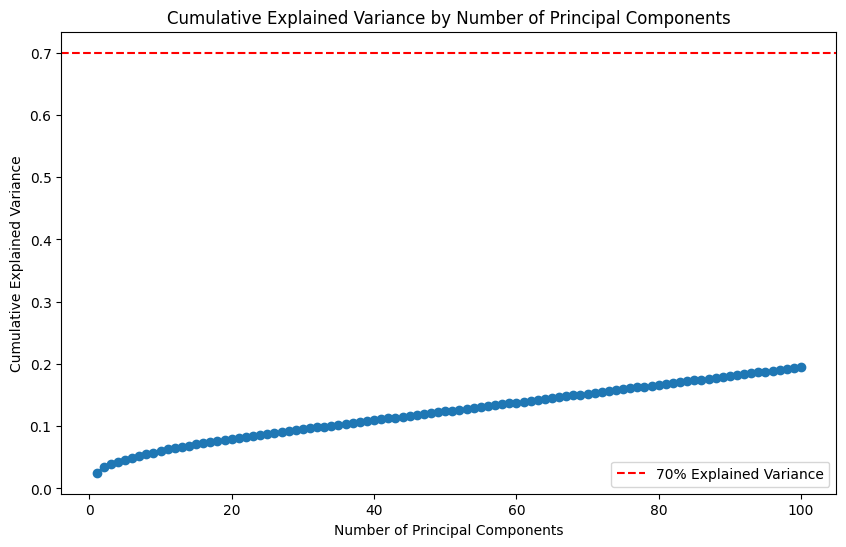

Explained variance ratio: [0.02532329 0.00869003 0.00581119 0.00337585 0.00312139 0.00290884
 0.00289375 0.00284076 0.00283049 0.00255377 0.00241702 0.0021328
 0.00207352 0.00205976 0.00200957 0.0019458  0.00186039 0.00181756
 0.00169887 0.00166119 0.00163091 0.00159422 0.00157665 0.00152218
 0.00150624 0.00149774 0.00148163 0.00147525 0.00146646 0.00145496
 0.00145056 0.00144553 0.00144178 0.0014391  0.00143591 0.00143385
 0.00143089 0.00142979 0.00142881 0.00142671 0.00142545 0.00142483
 0.00142419 0.00142395 0.00142367 0.00142362 0.00142357 0.00142352
 0.00142345 0.00142335 0.00142333 0.00142332 0.00142329 0.00142319
 0.00142317 0.00142313 0.00142307 0.00142302 0.001423   0.00142298
 0.00142296 0.00142292 0.0014229  0.00142287 0.00142286 0.00142283
 0.00142277 0.00142271 0.00142269 0.00142268 0.00142267 0.00142263
 0.00142261 0.00142259 0.00142254 0.00142253 0.00142252 0.0014225
 0.00142248 0.00142244 0.00142243 0.00142242 0.00142241 0.00142238
 0.00142235 0.00142234 0.00142229 0.00

In [24]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 전처리 코드 (기존 코드와 동일)
train_data = after_missing_data

# 1. 수치형 변수의 결측치를 중앙값으로 대체
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    if train_data[col].isnull().sum() > 0:
        train_data[col].fillna(train_data[col].median(), inplace=True)

# 2. 범주형 변수의 결측치를 최빈값으로 대체
cat_cols = train_data.select_dtypes(include=['object']).columns
for col in cat_cols:
    if train_data[col].isnull().sum() > 0:
        train_data[col].fillna(train_data[col].mode()[0], inplace=True)

# 3. 범주형 변수 원-핫 인코딩
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_cat_data = encoder.fit_transform(train_data[cat_cols])
encoded_cat_df = pd.DataFrame(encoded_cat_data, columns=encoder.get_feature_names_out(cat_cols))

# 수치형 데이터와 인코딩된 범주형 데이터 결합
processed_data = pd.concat([train_data[numeric_cols], encoded_cat_df], axis=1)

# 4. 데이터 표준화
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_data)

# 5. PCA 적용 - 100개의 주성분으로 설정
pca = PCA(n_components=100)
pca_result = pca.fit_transform(scaled_data)

# PCA 성분별 중요도 확인 및 누적 설명된 분산 비율 계산
explained_variances = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variances)

# 누적 설명된 분산 비율 시각화 (엘보우 방법)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Cumulative Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.axhline(y=0.7, color='r', linestyle='--', label='70% Explained Variance')
plt.legend()
plt.show()

# PCA 성분별 중요도 확인
print(f'Explained variance ratio: {explained_variances}')
print(f'Cumulative explained variance: {cumulative_variance}')

In [27]:
# 해석
# 주성분 1의 분산 비율이 0.0253(약 2.53%)
# 주성분 2의 분산 비율이 0.0087(약 0.87%)가 나왔다
# 그러니까 2.53+0.87=3.4%정도로 
# 결측치 처리한 이 데이터의 96.6% 정보가 1, 2번째 말고 다른데에 분포 되어있다라고 볼 수 있음
# 이렇게 낮은 이유는 주요한 정보는 더 높은 차원의 주성분에 존재할 가능성이 높다고 볼 수 있다

In [28]:
pip install imbalanced-learn

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 결측치 처리된 데이터프레임 사용
train_data = after_missing_data.copy()

# 2. 수치형 변수의 결측치를 중앙값으로 대체 (이미 처리된 데이터셋을 다시 처리)
numeric_cols = train_data.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_cols:
    train_data[col].fillna(train_data[col].median(), inplace=True)

# 3. 범주형 변수의 결측치를 최빈값으로 대체 (이미 처리된 데이터셋을 다시 처리)
cat_cols = train_data.select_dtypes(include=['object']).columns
for col in cat_cols:
    train_data[col].fillna(train_data[col].mode()[0], inplace=True)

# 4. 이상치 처리 (IQR 방법 사용)
for col in numeric_cols:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    # IQR 범위를 벗어나는 데이터 제거
    train_data = train_data[~((train_data[col] < (Q1 - 1.5 * IQR)) | (train_data[col] > (Q3 + 1.5 * IQR)))]

# 5. 범주형 변수 원-핫 인코딩
encoder = OneHotEncoder(sparse=False, drop='first')
encoded_cat_data = encoder.fit_transform(train_data[cat_cols])
encoded_cat_df = pd.DataFrame(encoded_cat_data, columns=encoder.get_feature_names_out(cat_cols))

# 6. 수치형 데이터와 인코딩된 범주형 데이터 결합
processed_data = pd.concat([train_data[numeric_cols], encoded_cat_df], axis=1)

# 7. 데이터 표준화 (스케일링)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(processed_data)

# 8. 레이블 데이터 준비 (결측치 없는지 확인)
y = train_data['target'].copy()  # 실제 레이블 컬럼 이름으로 바꿔야 함

# 레이블 데이터의 결측치 확인 및 제거 (필요 시)
if y.isnull().sum() > 0:
    y.fillna(y.mode()[0], inplace=True)  # 최빈값으로 대체

# 9. SMOTE 적용
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(scaled_data, y)

# 10. PCA 적용
pca = PCA(n_components=20)
pca_result = pca.fit_transform(X_resampled)

# PCA 결과 시각화
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y_resampled, alpha=0.3, cmap='viridis')
plt.title('PCA of Processed Data with SMOTE')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Target')
plt.show()

# PCA 성분별 중요도 확인
explained_variances = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variances)
print(f'Explained variance ratio: {explained_variances}')
print(f'Cumulative explained variance: {cumulative_variance}')


/home/elicer/.local/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
#이상치 처리 (IQR 방법)
for col in numeric_cols:
    Q1 = train_data[col].quantile(0.25)
    Q3 = train_data[col].quantile(0.75)
    IQR = Q3 - Q1
    train_data = train_data[~((train_data[col] < (Q1 - 1.5 * IQR)) | (train_data[col] > (Q3 + 1.5 * IQR)))]

## 3. 모델 학습


### 모델 정의


In [ ]:
model = RandomForestClassifier(random_state=RANDOM_STATE)

### 모델 학습


In [ ]:
features = []

for col in df_train.columns:
    try:
        df_train[col] = df_train[col].astype(int)
        features.append(col)
    except:
        continue

train_x = df_train[features]
train_y = df_train["target"]

model.fit(train_x, train_y)

## 4. 제출하기


### 테스트 데이터 예측


테스트 데이터 불러오기


In [ ]:
test_data = pd.read_csv(os.path.join(ROOT_DIR, "test.csv"))

In [ ]:
df_test_x = test_data[features]

for col in df_test_x.columns:
    try:
        df_test_x.loc[:, col] = df_test_x[col].astype(int)
    except:
        continue

In [ ]:
test_pred = model.predict(df_test_x)
test_pred

### 제출 파일 작성


In [ ]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["target"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**
